<a href="https://colab.research.google.com/github/prathamnishad/RNNs/blob/master/Time_series_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dense
from keras.layers import Dropout
import numpy as np
import warnings
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
warnings.filterwarnings("ignore")
os.chdir("/content/drive/My Drive")

In [6]:
df=pd.read_csv(r"wrfrun.csv")
df=df[["yyyymmdd","Time","Pres","Spd","Relative Humidity","Den","Temp","Precipitation Rate"]]
df.columns=["ymd","time","pres","speed","hum","den","tem","precip"]
df=df[1:]
df["ymd"]=df["ymd"].apply(lambda x: str(x)[:-2])
df["time"]=df["time"].apply(lambda x: '0'*(4-len(str(x)))+str(x)+"00")
df.time=df.ymd.astype(object)+df.time.astype(object)
df.drop(columns="ymd",inplace=True)
df.time=df.time.apply(lambda x: pd.to_datetime(x))
for i in ["pres","speed","hum","den","tem","precip"]:
    df[i]=df[i].astype(float)
df.set_index('time',inplace=True)
df.head()

,pres,speed,hum,den,tem,precip
time,,,,,,
2007-03-01 00:00:00,964.8,5.67,62.1,1.273,-12.3,0.000
2007-03-01 01:00:00,964.9,5.61,66.8,1.274,-12.4,0.001
2007-03-01 02:00:00,965.0,5.04,76.3,1.275,-12.8,0.002
2007-03-01 03:00:00,964.9,4.19,77.4,1.276,-13.0,0.004
2007-03-01 04:00:00,964.7,3.17,76.4,1.276,-13.0,0.005


In [0]:
train=df[:-len(df)//5]
test=df[-len(df)//5:]
scaler=MinMaxScaler()
scaler.fit(train)
train=scaler.transform(train)
test=scaler.transform(test)

In [0]:
# import numpy as np
# train_x=[]
# train_y=[]
# for i in range(0,len(train),24):
#   train_x.append(np.array(train[i:i+24]))
# for i in range(24,len(train),24):
#   train_y.append(train[i][1])
# if len(test[-1]!=24):
#   train_x=train_x[:-1]
# train_x=np.array(train_x)
# #############################
# test_x=[]
# test_y=[]
# for i in range(0,len(test),24):
#   test_x.append(np.array(test[i:i+24]))
# for i in range(24,len(test),24):
#   test_y.append(test[i][1])
# if len(test[-1]!=24):
#   test_x=test_x[:-1]
# test_x=np.array(test_x)
# print(len(test_x),len(test_y))

In [0]:
lag=10

In [0]:
import numpy as np
lag=10
tr=[]
train_x=[]
train_y=[]
for i in range(0,len(train)-lag):
  tr.append([train[i:i+lag],train[i+lag][1]])
tr=np.array(tr)
#############################
tt=[]
test_x=[]
test_y=[]
for i in range(0,len(test)-10):
  tt.append([test[i:i+lag],test[i+lag][1]])
t=np.array(tt)

In [90]:
import random
random.shuffle(tr)
random.shuffle(tt)
for i in range(len(tr)):
  train_x.append(tr[i][0])
  train_y.append(tr[i][1])
for i in range(len(tt)):
  test_x.append(tt[i][0])
  test_y.append(tt[i][1])
print(len(train_x),len(test_x))

70127 17525


In [0]:
train_x=np.array(train_x)
test_x=np.array(test_x)

In [0]:
# fig,ax=plt.subplots(6,1,figsize=(12,15))
# n=0
# for i in ["pres","speed","hum","den","tem","precip"]:
#   ax[n].plot(df[i][::500])
#   ax[n].set_title(i)
#   n+=1
# plt.show()

In [92]:
from keras.layers import BatchNormalization
model=Sequential()
model.add(LSTM(128,activation="relu", input_shape=(lag,6), return_sequences=True))
model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

model.add(LSTM(128,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1 , activation ="linear"))
model.compile(optimizer="adam",loss="mse")
model.fit(train_x,train_y,epochs=15,batch_size=128,validation_data=(test_x,test_y))

Train on 70127 samples, validate on 17525 samples
Epoch 1/15
70127/70127 [==============================] - 38s 546us/step - loss: 0.0166 - val_loss: 0.0258
Epoch 2/15
70127/70127 [==============================] - 37s 530us/step - loss: 0.0030 - val_loss: 0.0034
Epoch 3/15
70127/70127 [==============================] - 37s 530us/step - loss: 0.0021 - val_loss: 0.0034
Epoch 4/15
70127/70127 [==============================] - 37s 530us/step - loss: 0.0019 - val_loss: 0.0044
Epoch 5/15
70127/70127 [==============================] - 37s 525us/step - loss: 0.0018 - val_loss: 0.0035
Epoch 6/15
70127/70127 [==============================] - 37s 528us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 7/15
70127/70127 [==============================] - 37s 529us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 8/15
70127/70127 [==============================] - 37s 527us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 9/15
70127/70127 [==============================] - 37s 524us/step - loss: 0.0014 - val_

In [0]:
pred=model.predict(test_x)

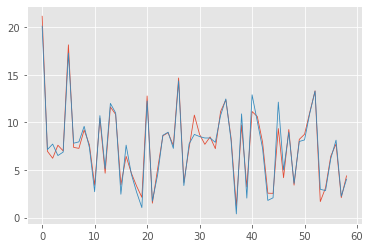

In [94]:
plt.style.use("ggplot")
a1=np.array(pred)*25
a2=np.array(test_y)*25
plt.plot(a1[::300],linewidth=0.8)
plt.plot(a2[::300],linewidth=0.8)
plt.show()

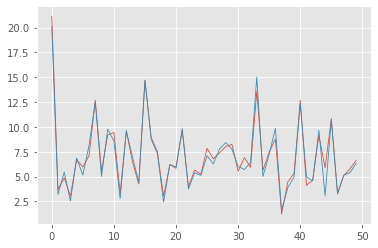

In [97]:
plt.plot(a1[:50],linewidth=0.8)
plt.plot(a2[:50],linewidth=0.8)

In [0]:
model.save(f"TS{lag}")

In [0]:
from keras.models import load_model
new_model = load_model(f"TS{lag}")

# Check its architecture
new_model.summary()

In [0]:
y1=new_model.predict(test_x)

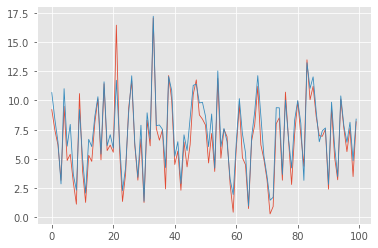

In [88]:
plt.plot(np.array(y1[:100])*25,linewidth=0.8)
plt.plot(a2[:100],linewidth=0.8)